based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.



In [2]:
import sys,os,glob
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)

import jhat
from jhat import jwst_photclass,st_wcs_align

2024-09-10 15:02:47,868 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 CANNOT BE CHECKED AGAINST ONLINE VERSION




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [17]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Examine the Reference Image**




In [3]:
ref_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcb1_cal.fits')[0]

ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='linear',min_cut=-.5,max_cut=3)

plt.imshow(ref_data, origin='lower',
                      norm=norm1,cmap='gray')
plt.gca().tick_params(labelcolor='none',axis='both',color='none')
plt.show()

**Zoom in to see the offset**

Here add an artificial offset to the wcs, and then we see the 
same star in both images at the same ra/dec
location, demonstrating a large offset between
the images.  



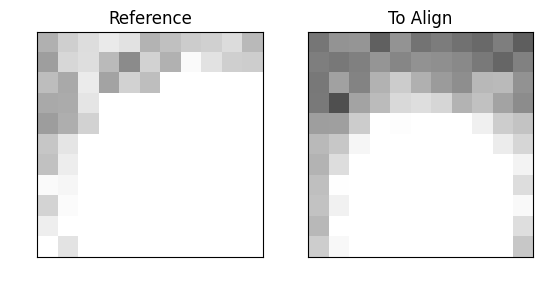

In [24]:
star_location = SkyCoord('23:09:41.0532','-43:26:41.128',unit=(u.hourangle,u.deg))
align_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcblong_cal.fits')[0]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=1
align_fits['SCI',1].header['CRPIX2']+=1
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='linear',min_cut=-.5,max_cut=3)
norm2 = simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [28]:
ref_image = glob.glob('jwstred_temp/jw02784002001_02101_00003_nrcb2_cal.fits')[0]

In [29]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp/jw02784002001_02101_00003_nrcb2_cal.phot.txt


2024-09-09 21:08:23,368 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-09 21:08:23,587 - CRDS - ERROR -  (FATAL) CRDS server connection and cache load FAILED.  Cannot continue.
 See https://hst-crds.stsci.edu/docs/cmdline_bestrefs/ or https://jwst-crds.stsci.edu/docs/cmdline_bestrefs/
 for more information on configuring CRDS,  particularly CRDS_PATH and CRDS_SERVER_URL. : [Errno 2] No such file or directory: '/grp/crds/cache/config/jwst/server_config'


dmag 0.36200000000000004
aper_sum_3.0px annulus_median_3.0px aper_bkg_3.0px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
     77.996287              0.49059      13.871114 ... -22.548043 -31.860379
    101.646245             2.686963      75.972088 ...  -30.11684 -31.801298
     35.713843             0.918047      25.957171 ... -28.081975 -31.838047
     18.865998             0.511587      14.464787 ... -14.053267 -31.865538
     38.161517             1.141975      32.288584 ... -30.720711 -31.782324
     23.279836             0.719236      20.335918 ...   8.183554 -31.820901
     45.705612              0.87402      24.712331 ...  11.778763 -31.799006
     35.100274             0.934992      26.436277 ... -23.503593 -31.754297
     33.281827             0.941021      26.606731 ... -23.400244 -31.773713
    379.553191             0.525168      14.848769 ...  20.469563 -31.776619
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [30]:
align_image = glob.glob('jwstred_temp/jw02784002001_02101_00002_nrcb2_cal.fits')[0]

0 ./jwstred_temp/jw02784002001_02101_00002_nrcb2.phot.txt


2024-09-09 21:12:12,750 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-09 21:12:12,929 - CRDS - ERROR -  (FATAL) CRDS server connection and cache load FAILED.  Cannot continue.
 See https://hst-crds.stsci.edu/docs/cmdline_bestrefs/ or https://jwst-crds.stsci.edu/docs/cmdline_bestrefs/
 for more information on configuring CRDS,  particularly CRDS_PATH and CRDS_SERVER_URL. : [Errno 2] No such file or directory: '/grp/crds/cache/config/jwst/server_config'


dmag 0.2172
dmag 1.0
sharpness 0.9
roundness1 0.7
mag 24
x 2008
y 2008
reffile_d2d 0.2
*** Note: close plot to continue!


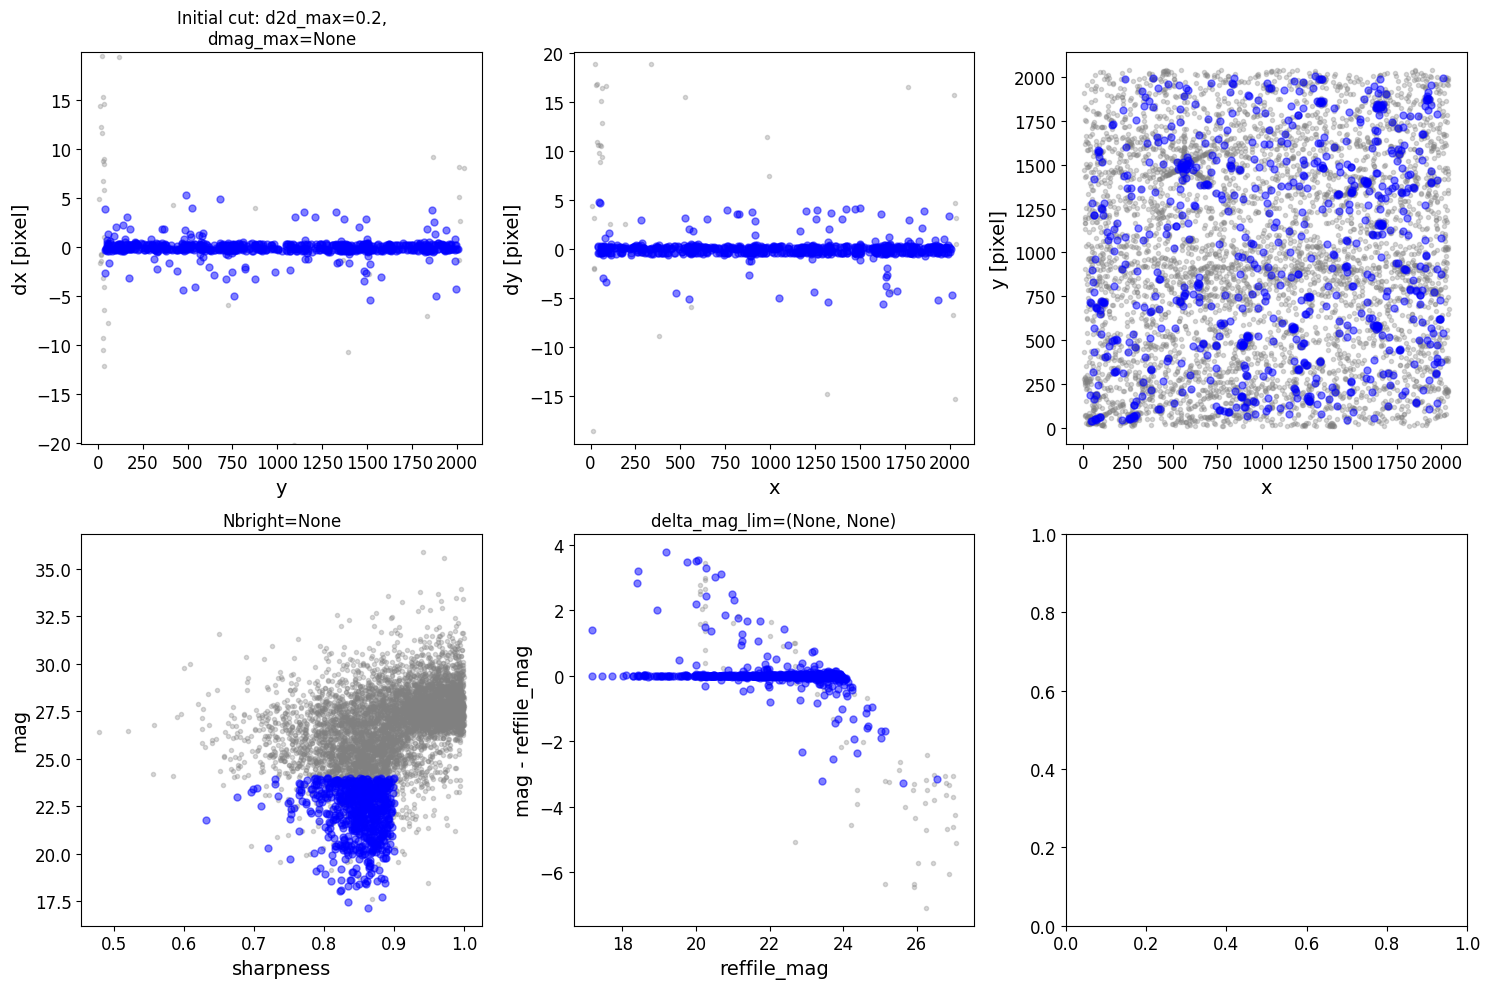

    slope  intercept     maxval  index  d_bestguess  fwhm  multimax
-0.000049       0.05 341.858323    289    -0.185287  0.94     False
d_rot_tmp 0.6147131474689431
Keeping 631 out of 631, skippin 0 because of null values in columns d_rot_tmp
median: -0.134225
75.000000 percentile cut: max residual for cut: 0.349397
__tmp_residuals 0.34939749112273044
median: -0.191927
i:00 mean:-0.191927(0.009454) stdev:0.205384(0.006678) X2norm:1.00 Nchanged:0 Ngood:473 Nclip:158

mean: -0.053533
i:01 mean:-0.053533(0.010422) stdev:0.258049(0.007364) X2norm:1.00 Nchanged:141 Ngood:614 Nclip:17

mean: -0.040749
i:02 mean:-0.040749(0.010691) stdev:0.267912(0.007554) X2norm:1.00 Nchanged:15 Ngood:629 Nclip:2

mean: -0.042007
i:03 mean:-0.042007(0.010748) stdev:0.269553(0.007594) X2norm:1.00 Nchanged:1 Ngood:630 Nclip:1

mean: -0.042007
i:04 mean:-0.042007(0.010748) stdev:0.269553(0.007594) X2norm:1.00 Nchanged:0 Ngood:630 Nclip:1


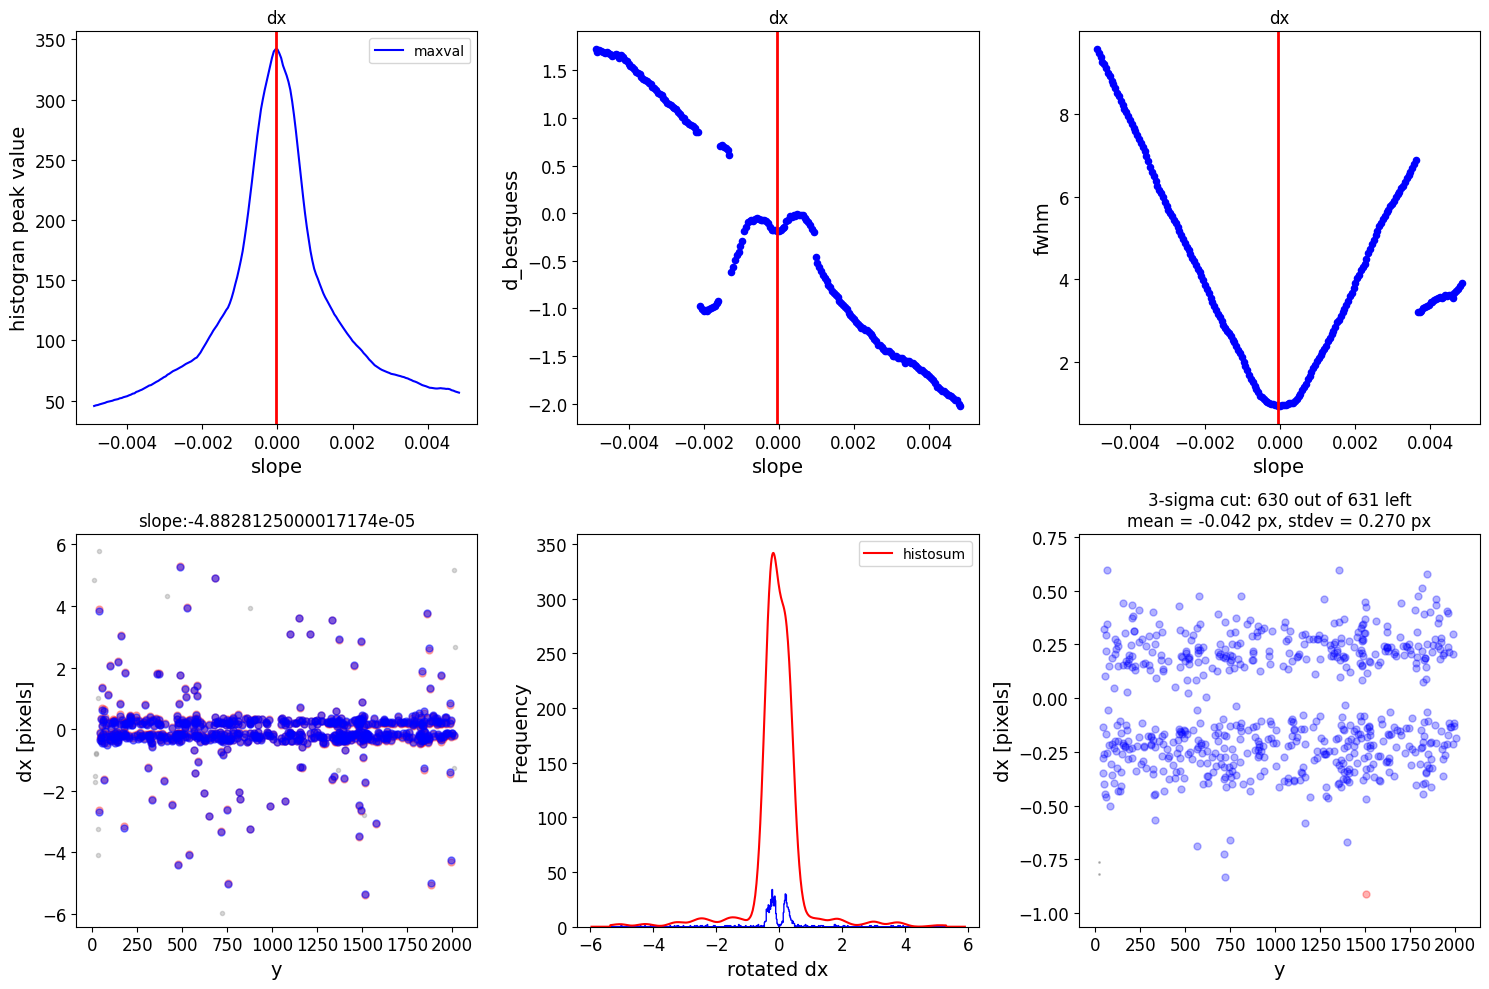

        slope    intercept     maxval  index  d_bestguess  fwhm  multimax
-1.734723e-17 1.776357e-14 354.254277    132     0.073789  0.94     False
d_rot_tmp 0.8737891929868915
Keeping 621 out of 621, skippin 0 because of null values in columns d_rot_tmp
median: 0.027063
75.000000 percentile cut: max residual for cut: 0.404743
__tmp_residuals 0.40474263757540735
median: 0.061629
i:00 mean:0.061629(0.008925) stdev:0.192244(0.006304) X2norm:1.00 Nchanged:0 Ngood:465 Nclip:156

mean: -0.064692
i:01 mean:-0.064692(0.010796) stdev:0.264438(0.007627) X2norm:1.00 Nchanged:136 Ngood:601 Nclip:20

mean: -0.077593
i:02 mean:-0.077593(0.011088) stdev:0.275655(0.007834) X2norm:1.00 Nchanged:18 Ngood:619 Nclip:2

mean: -0.077593
i:03 mean:-0.077593(0.011088) stdev:0.275655(0.007834) X2norm:1.00 Nchanged:0 Ngood:619 Nclip:2


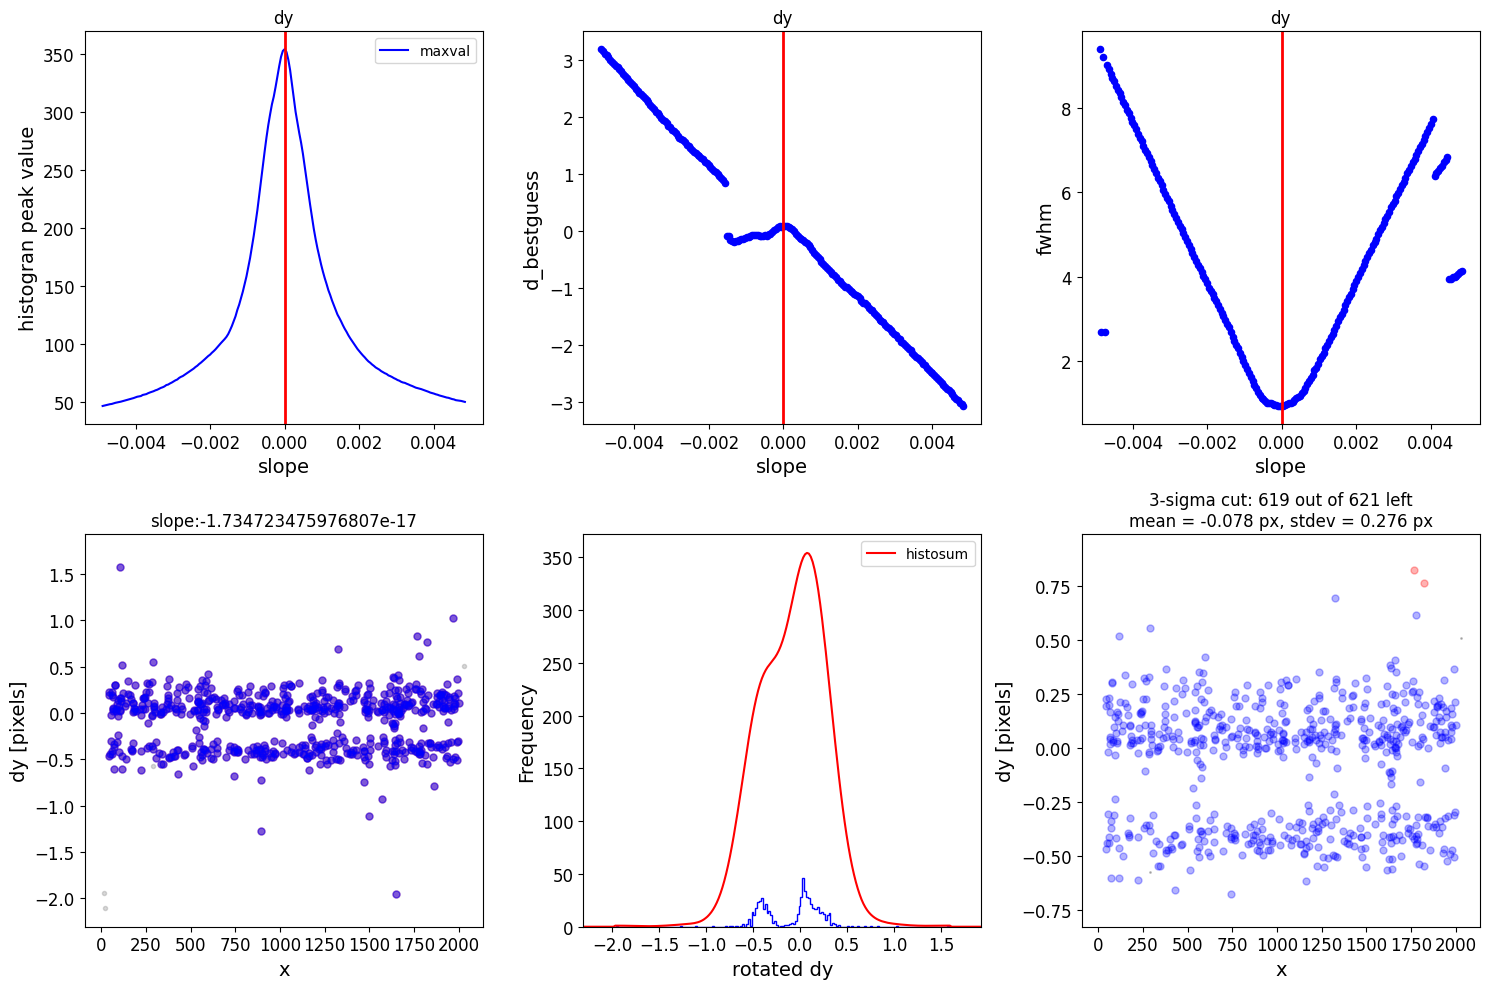

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-09 21:12:21,292 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-09 21:12:21,774 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw02784002001_02101_00002_nrcb2_cal.fits>],).
2024-09-09 21:12:21,778 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw02784002001_02101_00002_nrcb2_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: Fals

replacing SIP ./jwstred_temp/jw02784002001_02101_00002_nrcb2_jhat.fits


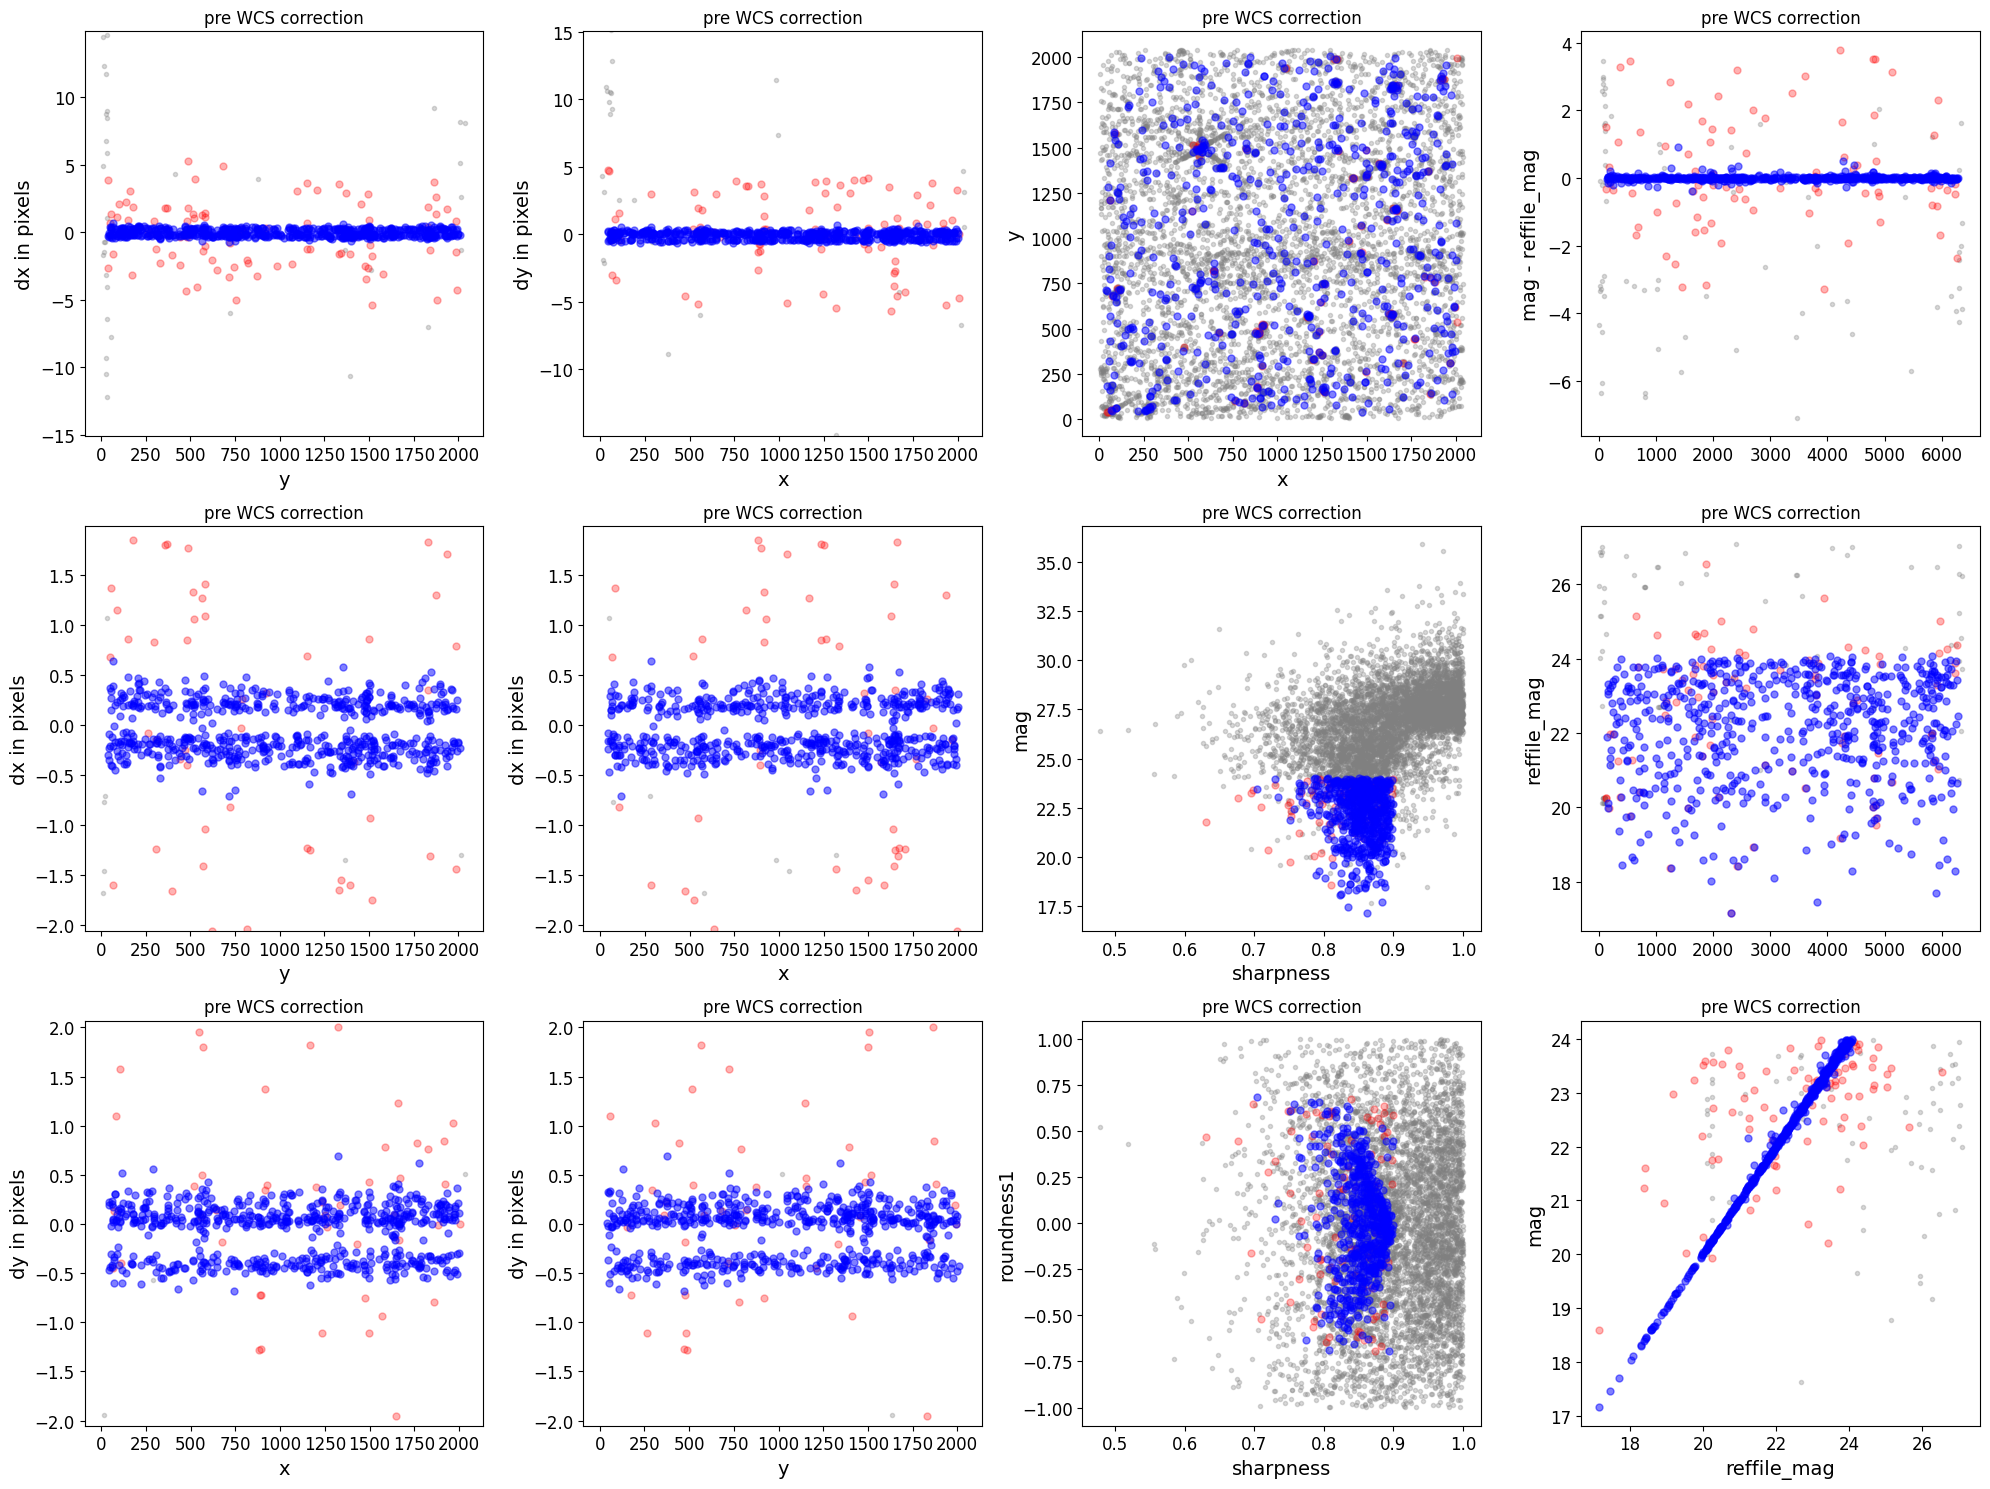

./jwstred_temp/jw02784002001_02101_00002_nrcb2_jhat.fits


*** Note: close plots to continue!


0

In [34]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.2,
          showplots=2,
          find_stars_threshold=5,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=1.0,
              objmag_lim =(14,24))

**Check the Output**

The reference image has not changed, but let's read in the newly
aligned image and compare with the original. 
subsequent correction needed for optimal alignment.



In [7]:
aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [4]:
align_image = glob.glob('jwstred_temp+gaia/jw02784002001_02101_00003_nrcb2_cal.fits')[0]

In [7]:
%matplotlib notebook

0 ./jwstred_temp/jw02784002001_02101_00003_nrcb2.phot.txt


2024-09-10 15:20:51,367 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-10 15:20:51,798 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-10 15:20:51,824 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-10 15:20:51,825 - stpipe - INFO - Instrument: NIRCAM
2024-09-10 15:20:51,826 - stpipe - INFO - Detector: NRCB2
2024-09-10 15:20:51,827 - stpipe - INFO - Filter: F115W
2024-09-10 15:20:51,828 - stpipe - INFO - Pupil: CLEAR
2024-09-10 15:20:51,829 - stpipe - INFO - Subarray: FULL
2024-09-10 15:20:51,883 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
dmag 1
sharpness 0.9
roundness1 0.7
mag 20


2024-09-10 15:41:26,842 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 164
### NO propoer motion correction!!!
Number of stars after removing nan's: 164
x 2008
y 2008
gaia_d2d 1


<IPython.core.display.Javascript object>


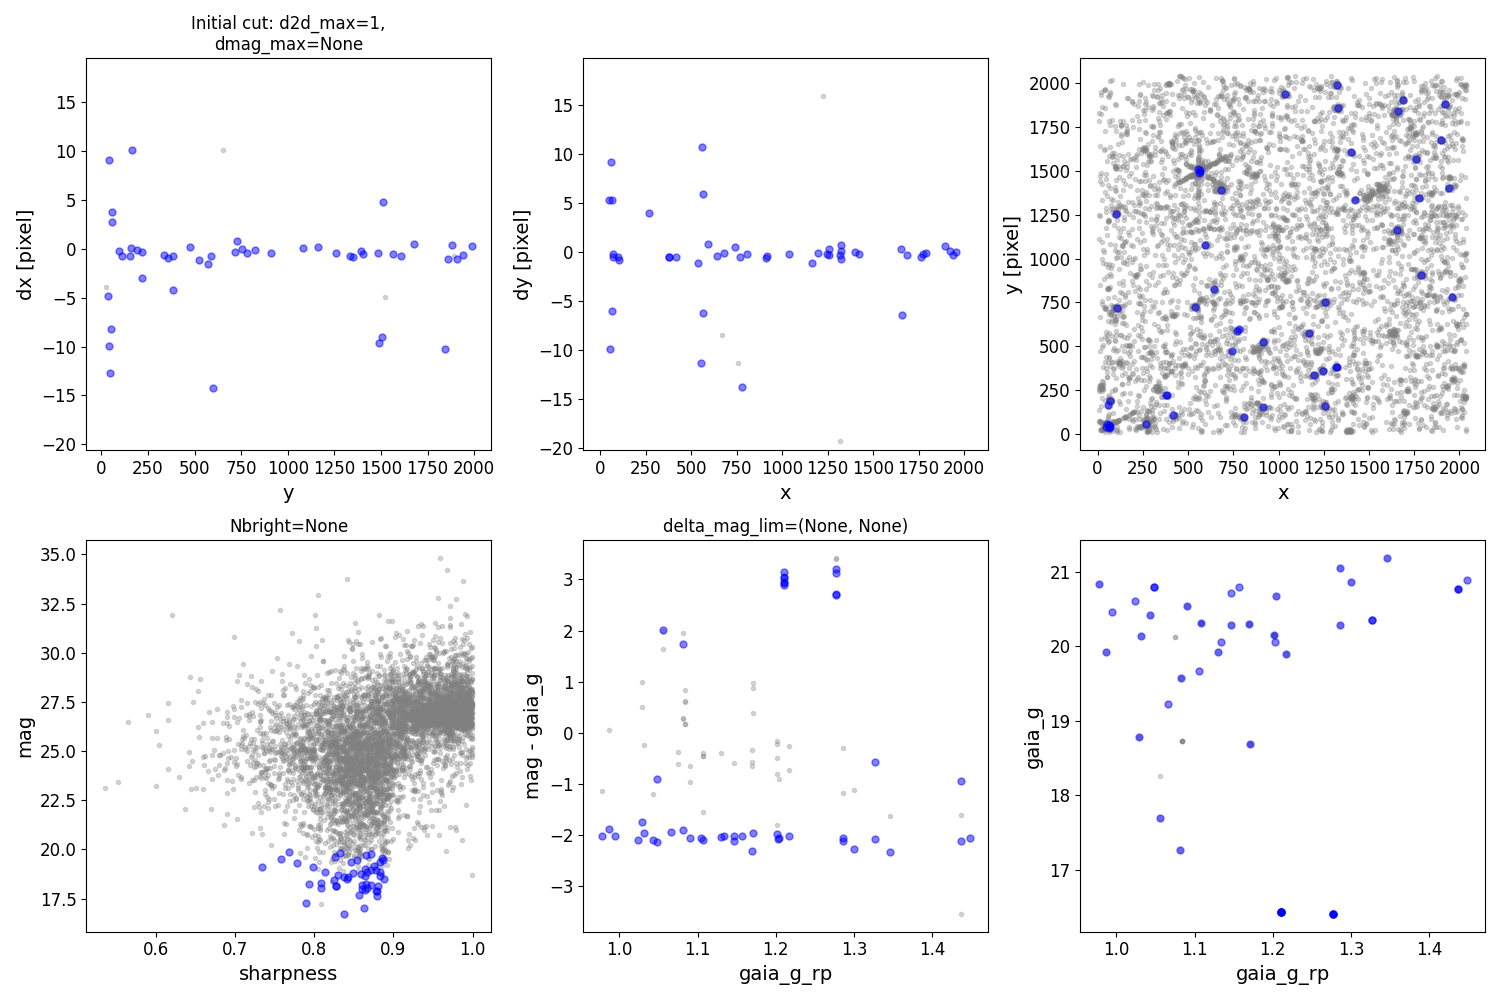

*** Note: close plot to continue!


<IPython.core.display.Javascript object>

    slope  intercept    maxval  index  d_bestguess  fwhm  multimax
-0.000293        0.3 14.091945    725    -0.503408  1.06     False
d_rot_tmp 0.2965920711122483
Keeping 29 out of 29, skippin 0 because of null values in columns d_rot_tmp
median: -0.474503
75.000000 percentile cut: max residual for cut: 0.375346
__tmp_residuals 0.3753462015623395
median: -0.474503
i:00 mean:-0.474503(0.050189) stdev:0.224451(0.034634) X2norm:0.98 Nchanged:0 Ngood:21 Nclip:8

mean: -0.512011
i:01 mean:-0.512011(0.060233) stdev:0.307129(0.041795) X2norm:1.00 Nchanged:6 Ngood:27 Nclip:2

mean: -0.509945
i:02 mean:-0.509945(0.066898) stdev:0.353991(0.046481) X2norm:1.00 Nchanged:2 Ngood:29 Nclip:0

mean: -0.509945
i:03 mean:-0.509945(0.066898) stdev:0.353991(0.046481) X2norm:1.00 Nchanged:0 Ngood:29 Nclip:0


<IPython.core.display.Javascript object>


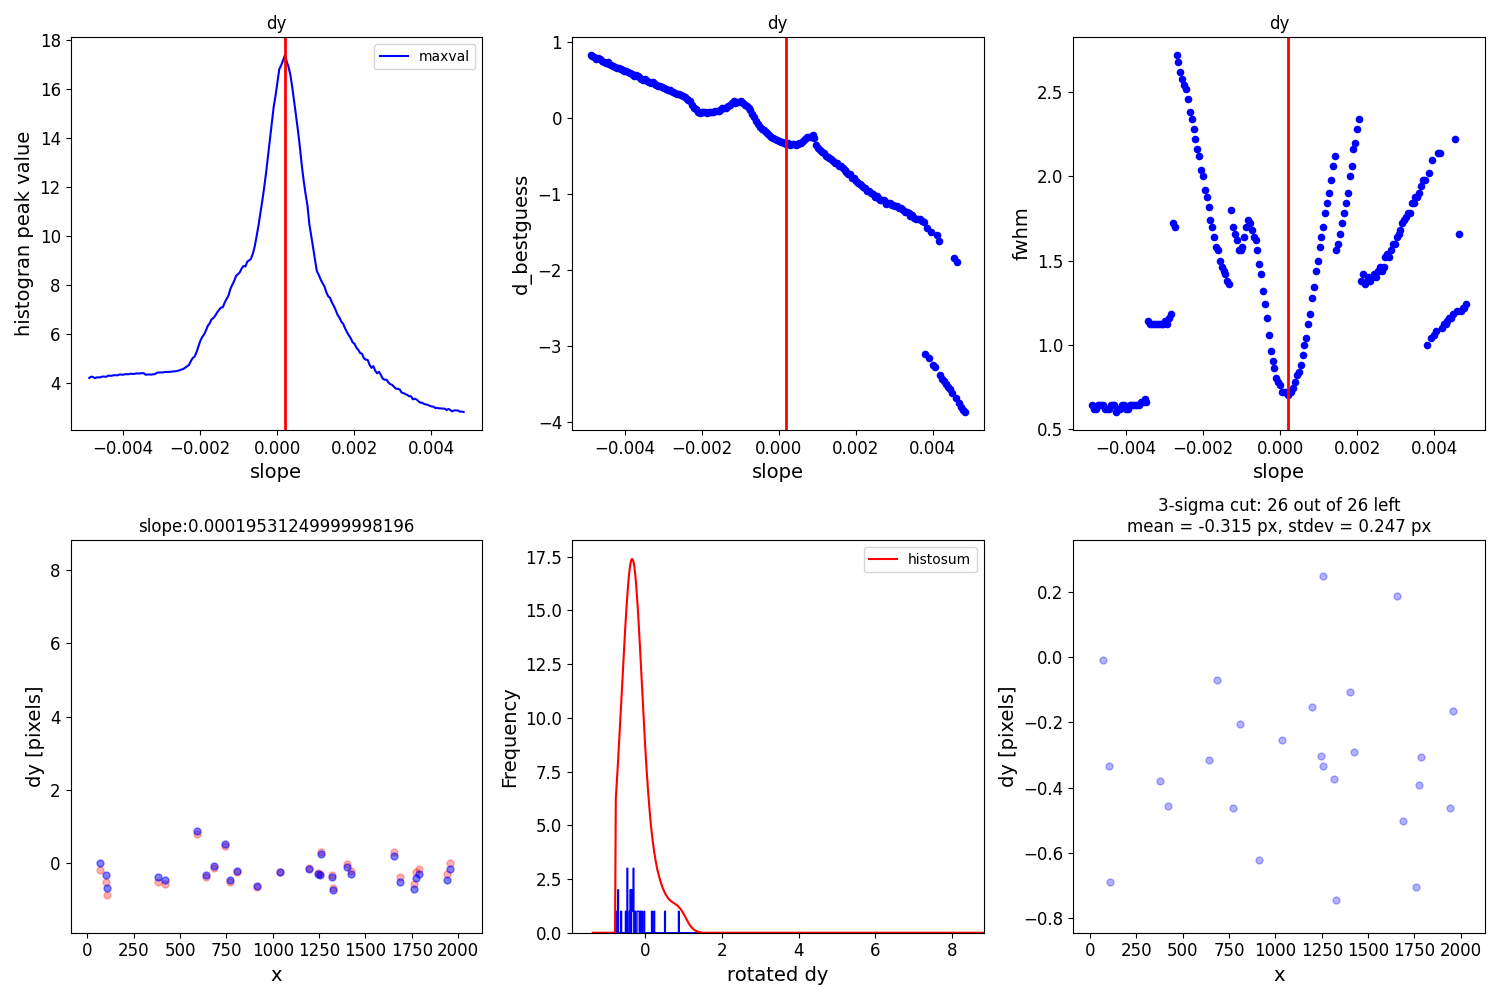

   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000195       -0.2 17.391991     51    -0.336158   0.7     False
d_rot_tmp 0.46384200604385417
Keeping 26 out of 26, skippin 0 because of null values in columns d_rot_tmp
median: -0.324791
75.000000 percentile cut: max residual for cut: 0.286940
__tmp_residuals 0.286940190017285
median: -0.316170
i:00 mean:-0.316170(0.029976) stdev:0.127177(0.020631) X2norm:0.97 Nchanged:0 Ngood:19 Nclip:7

mean: -0.326714
i:01 mean:-0.326714(0.037201) stdev:0.170477(0.025700) X2norm:1.00 Nchanged:3 Ngood:22 Nclip:4

mean: -0.359975
i:02 mean:-0.359975(0.041321) stdev:0.198167(0.028603) X2norm:1.00 Nchanged:2 Ngood:24 Nclip:2

mean: -0.338094
i:03 mean:-0.338094(0.045462) stdev:0.222718(0.031497) X2norm:1.00 Nchanged:1 Ngood:25 Nclip:1

mean: -0.315473
i:04 mean:-0.315473(0.049366) stdev:0.246828(0.034229) X2norm:1.00 Nchanged:1 Ngood:26 Nclip:0

mean: -0.315473
i:05 mean:-0.315473(0.049366) stdev:0.246828(0.034229) X2norm:1.00 Nchanged

2024-09-10 15:41:33,058 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.


*** Note: close plots to continue!


2024-09-10 15:41:33,605 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw02784002001_02101_00003_nrcb2_cal.fits>],).
2024-09-10 15:41:33,612 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw02784002001_02101_00003_nrcb2_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: False
  gaia_catalog: GAIADR2
  min_gaia: 30
  save_gaia_catalog: False
  telescope: jwst


replacing SIP ./jwstred_temp/jw02784002001_02101_00003_nrcb2_jhat.fits


<IPython.core.display.Javascript object>


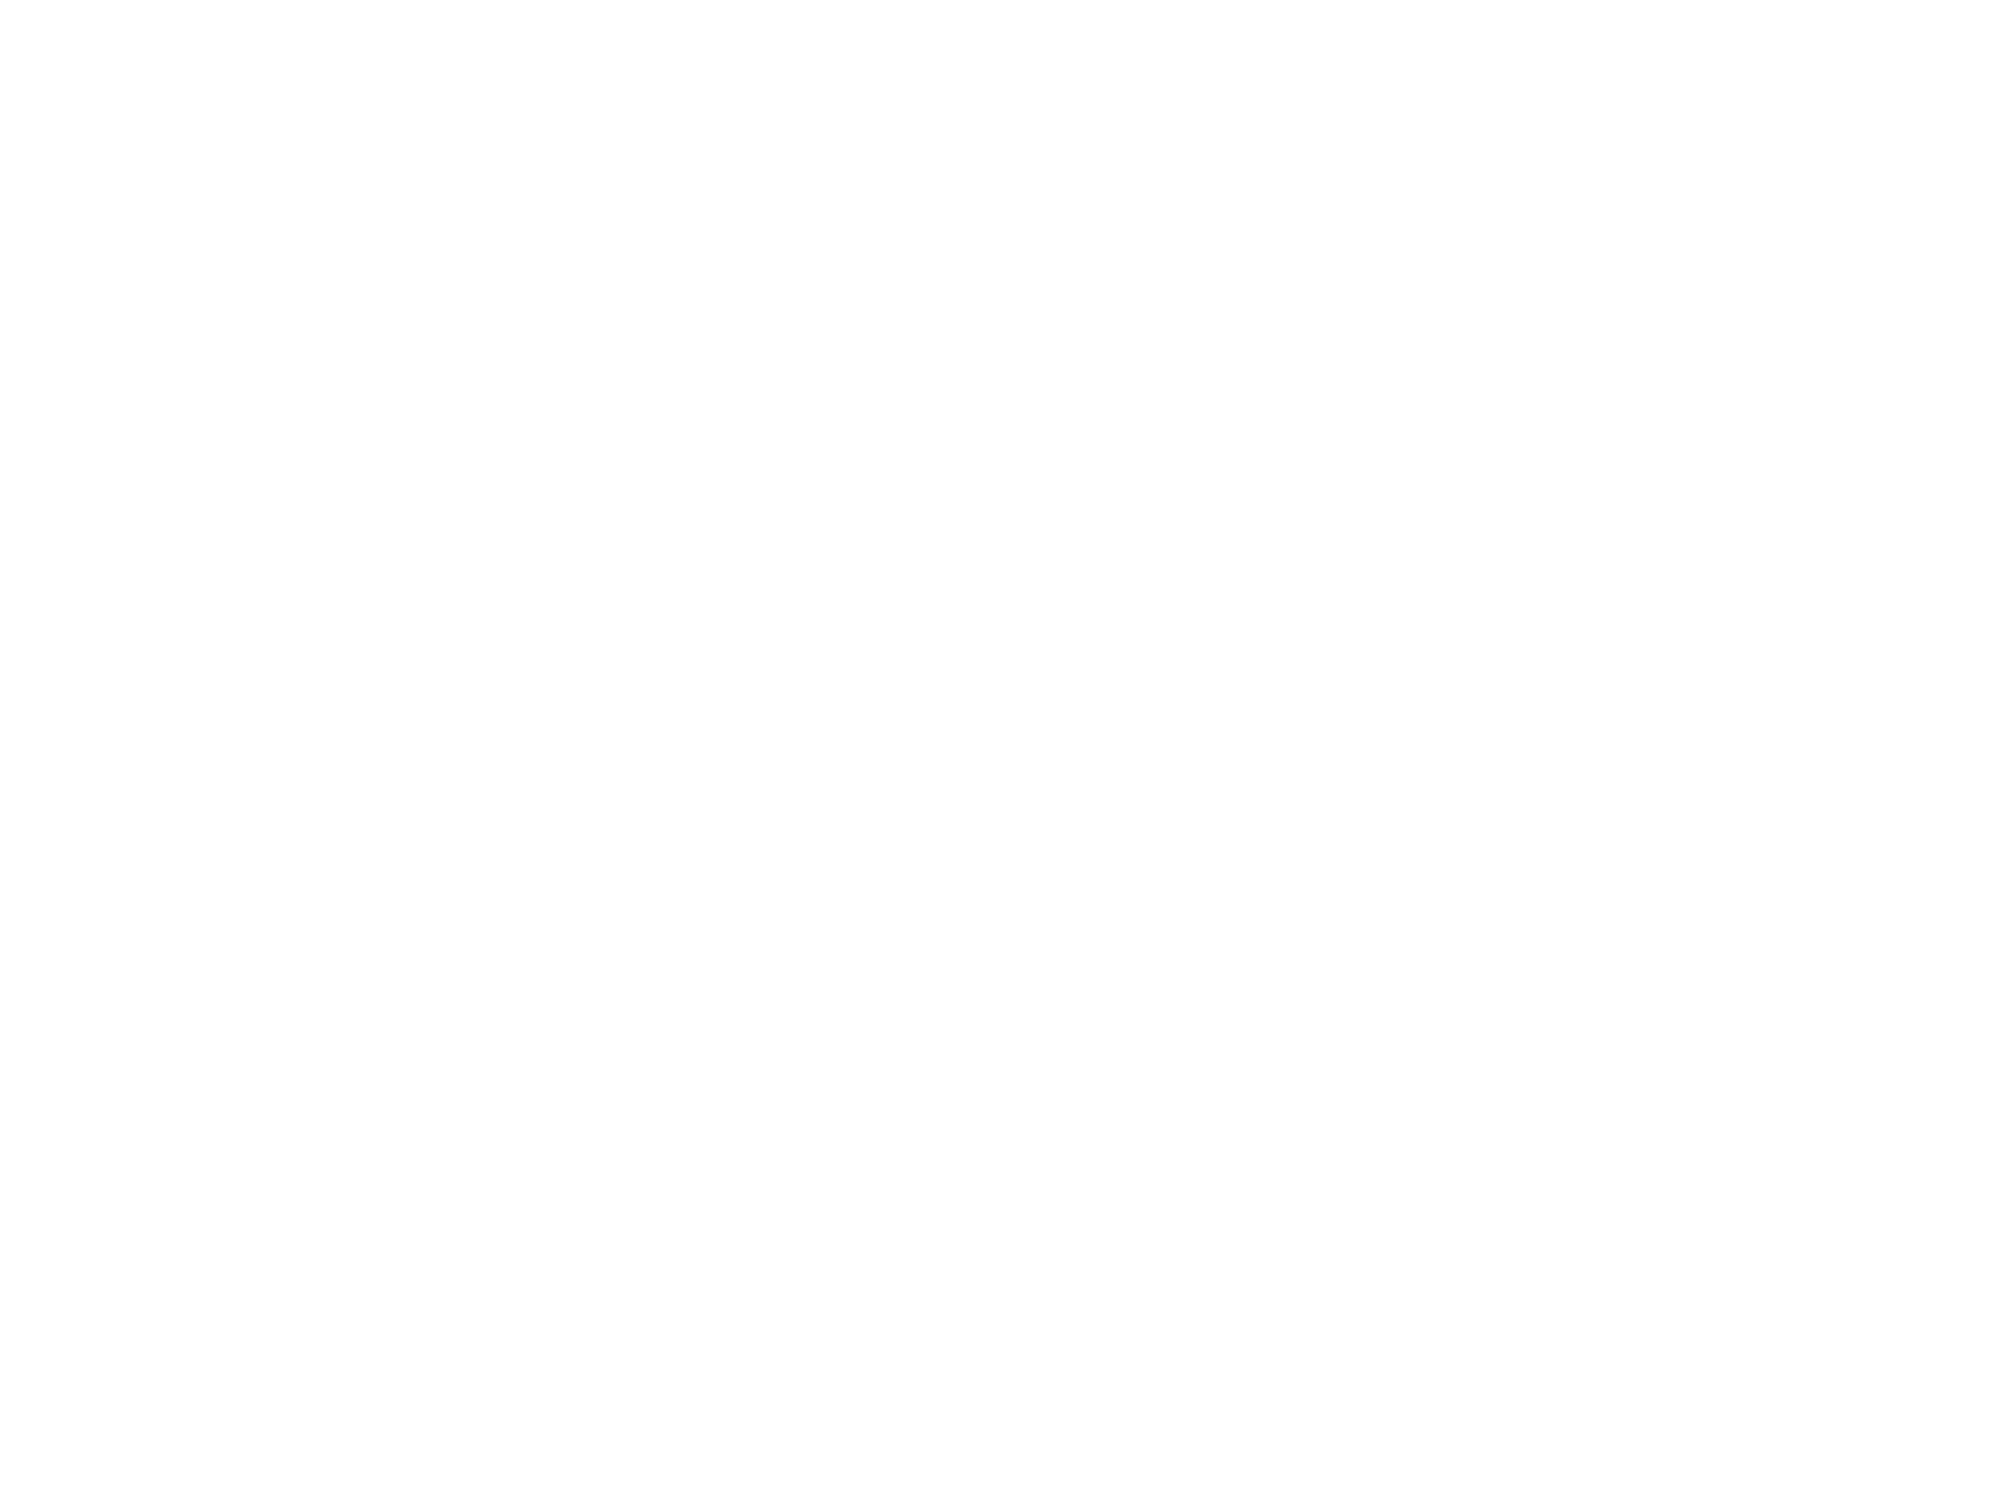

./jwstred_temp/jw02784002001_02101_00003_nrcb2_jhat.fits


<IPython.core.display.Javascript object>


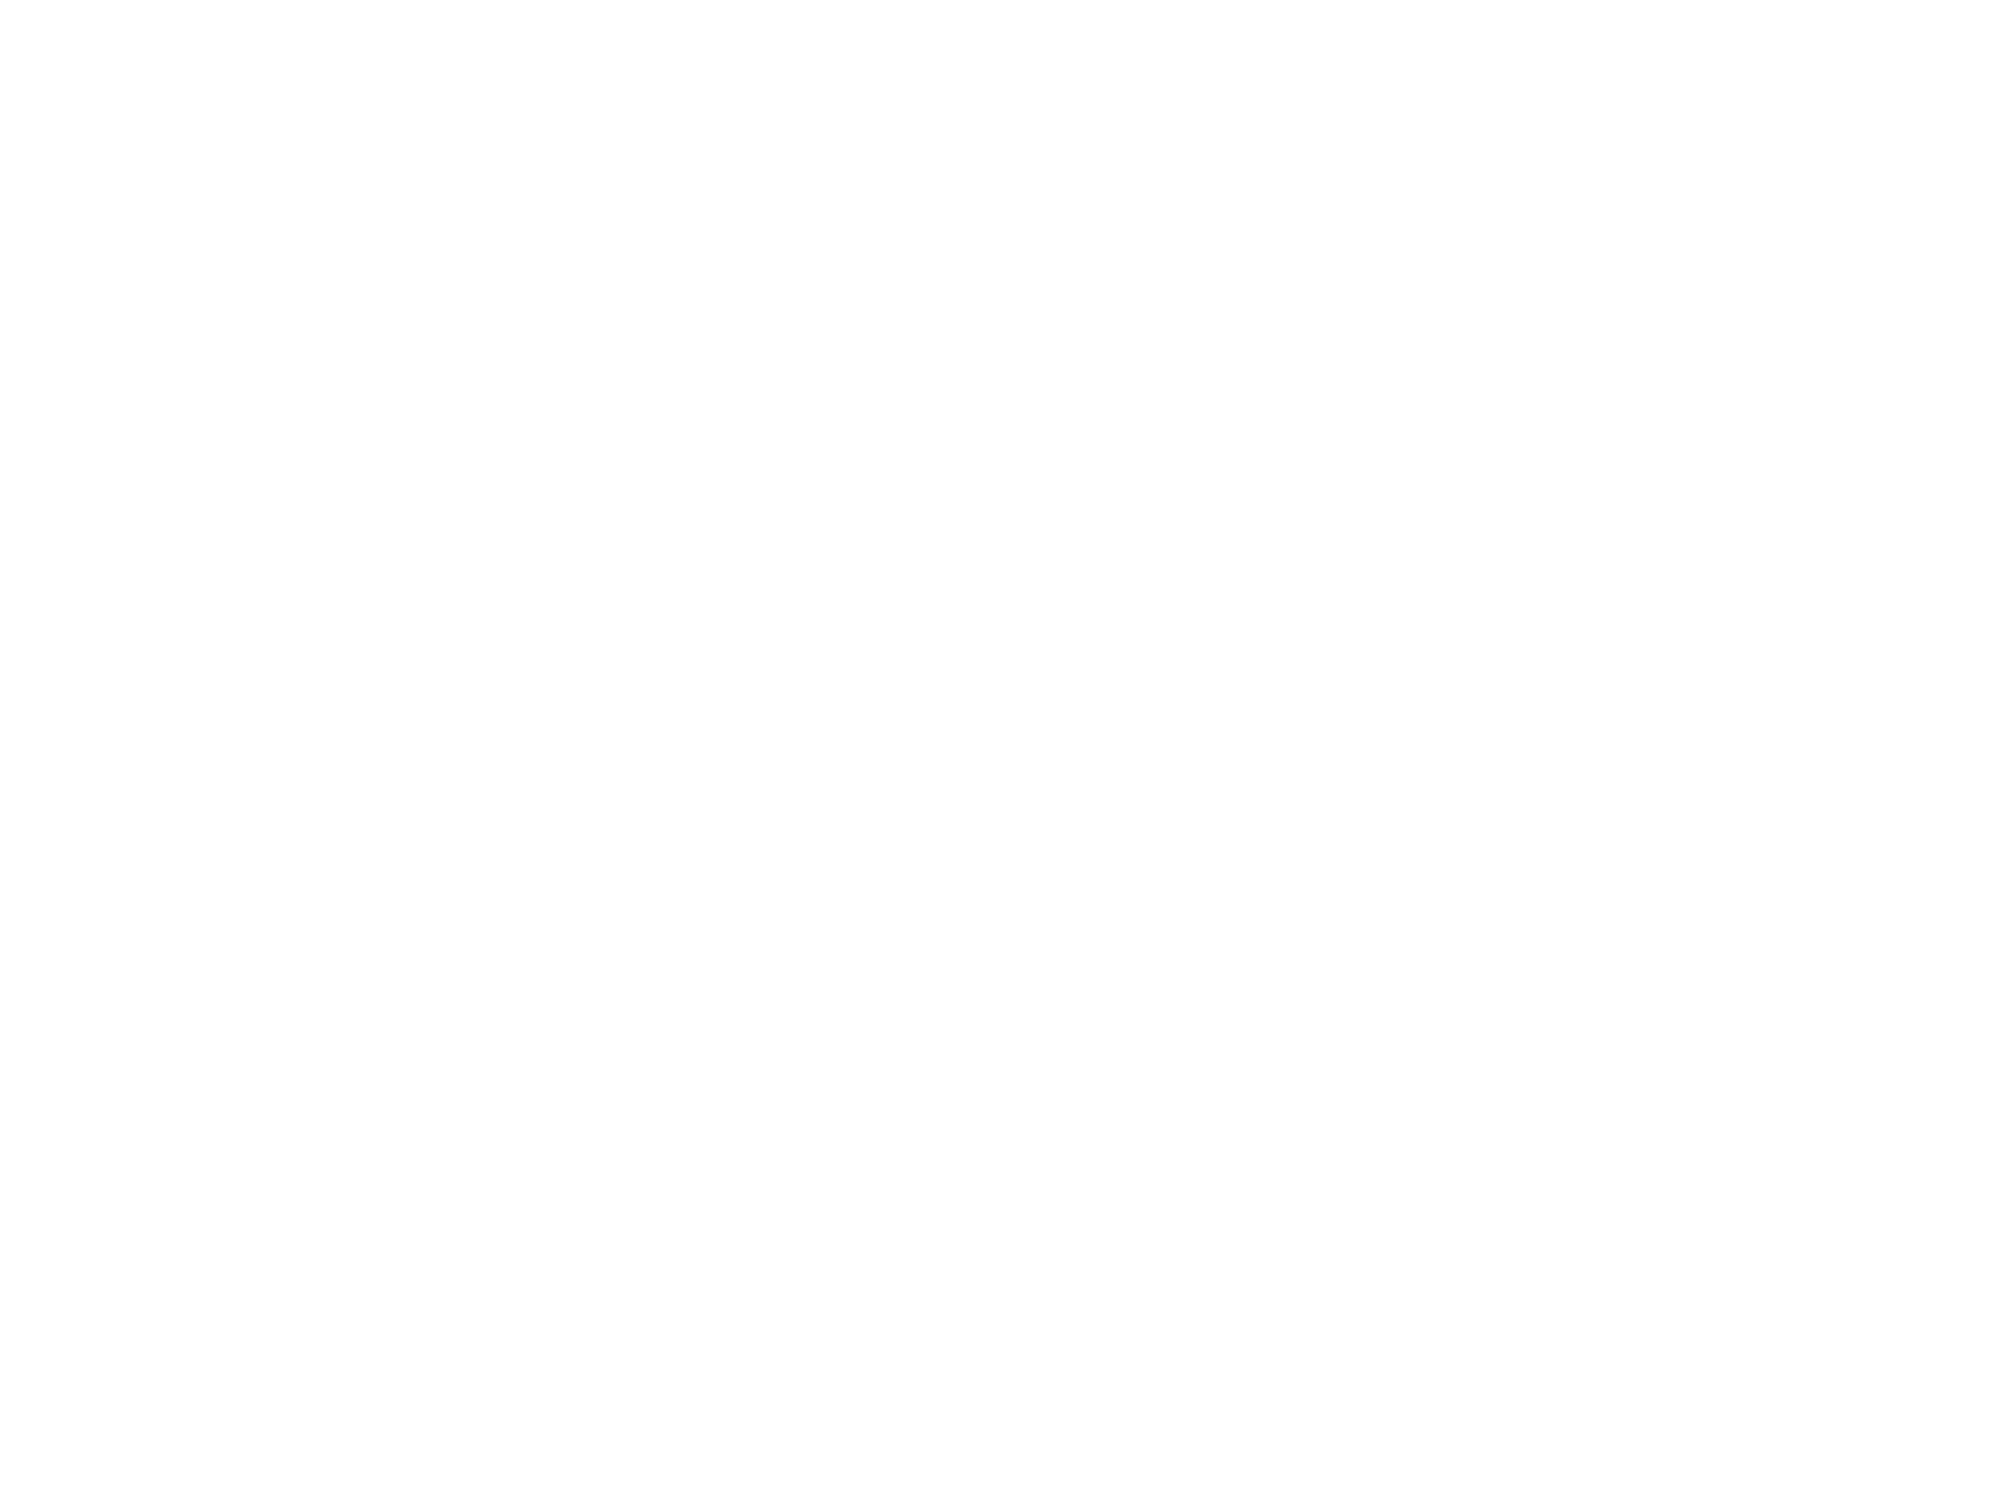

*** Note: close plots to continue!


0

In [9]:
wcs_align = st_wcs_align()

# if os.path.exists('Gaia_reference_catalog.txt'):
#     os.remove('Gaia_reference_catalog.txt')
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          overwrite=True,
          d2d_max=1,
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1,
              Nbright = 150,
              objmag_lim =(15,20))

# aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
# aligned_fits = fits.open(aligned_image)
# aligned_data = fits.open(aligned_image)['SCI',1].data
# aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
# aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

# norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
# fig,axes = plt.subplots(1,2)
# axes[0].imshow(align_cutout, origin='lower',
#                       norm=norm2,cmap='gray')
# axes[1].imshow(aligned_cutout, origin='lower',
#                       norm=norm3,cmap='gray')
# axes[0].set_title('To Align')
# axes[1].set_title('Aligned')
# for i in range(2):
# 	axes[i].tick_params(labelcolor='none',axis='both',color='none')


# plt.show()

In [ ]:
#XSH: 0.00901881  YSH: 0.0210673    ROT: -0.0101848
#XSH: 0.00941756  YSH: 0.0222109    ROT: -0.00777701

In [32]:
norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()